📂 成功加载数据: mcm26Train-B-Data/hall_calls.csv
📂 输出目录已就绪: c:\Users\ROG\Desktop\MCM_B\MCM2026\MCM_Simulation_Results

🎲 [图1] 单日详情分析: 2025-11-15


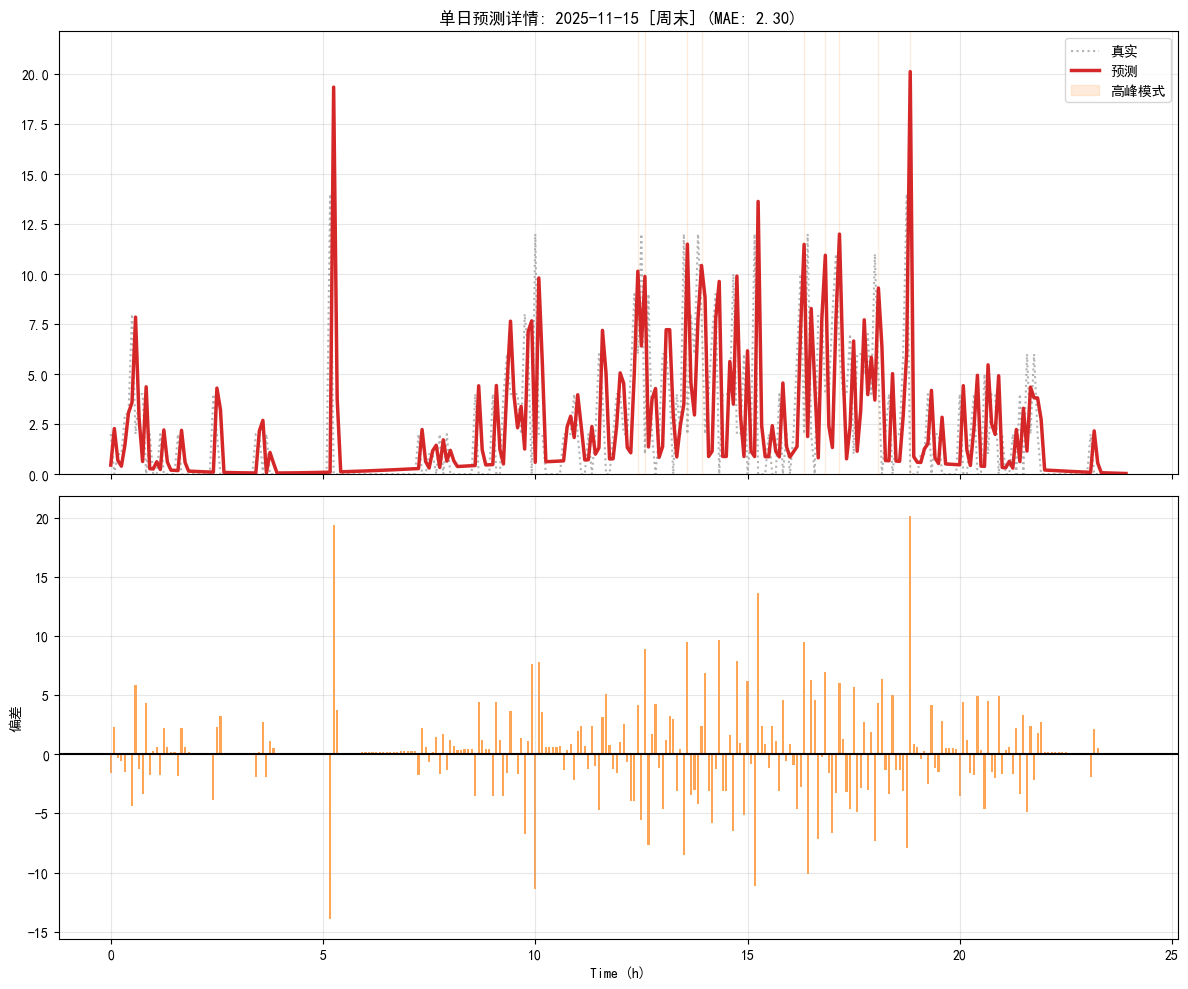


📊 [图2] 全月趋势分析...


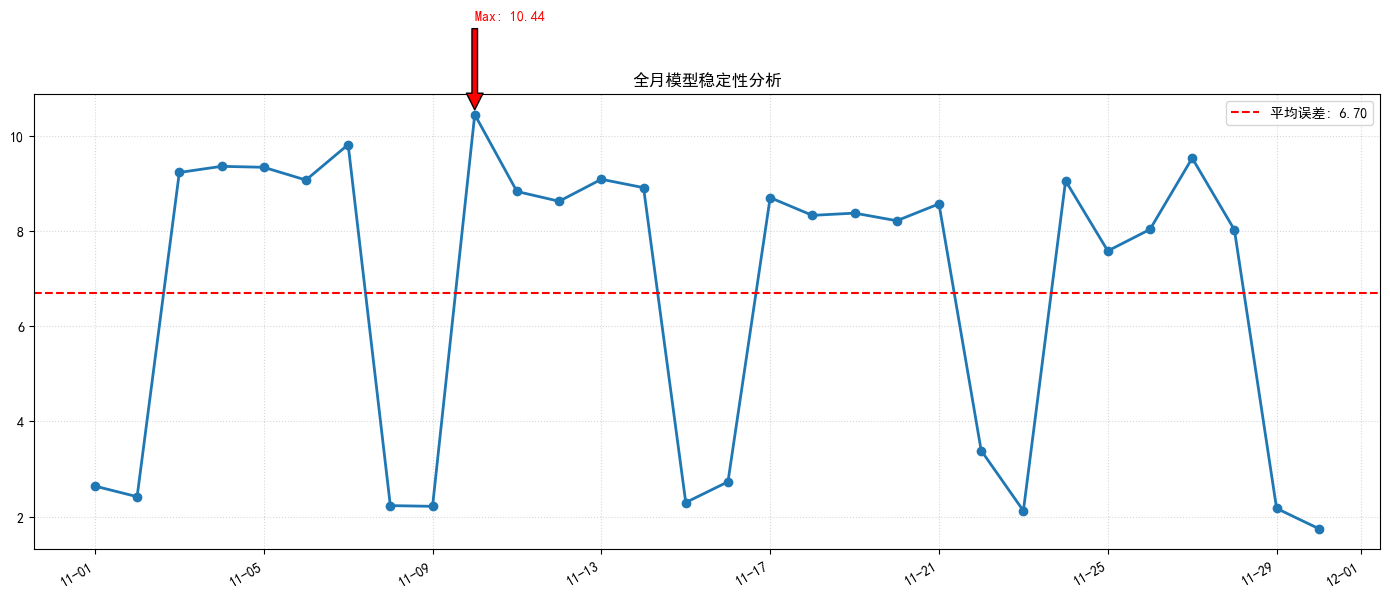


🚀 [图3] Task 3 深度仿真 (负载均衡测试)...
🔥 压测场景: 2025-11-03 | 高峰时段: 18:00


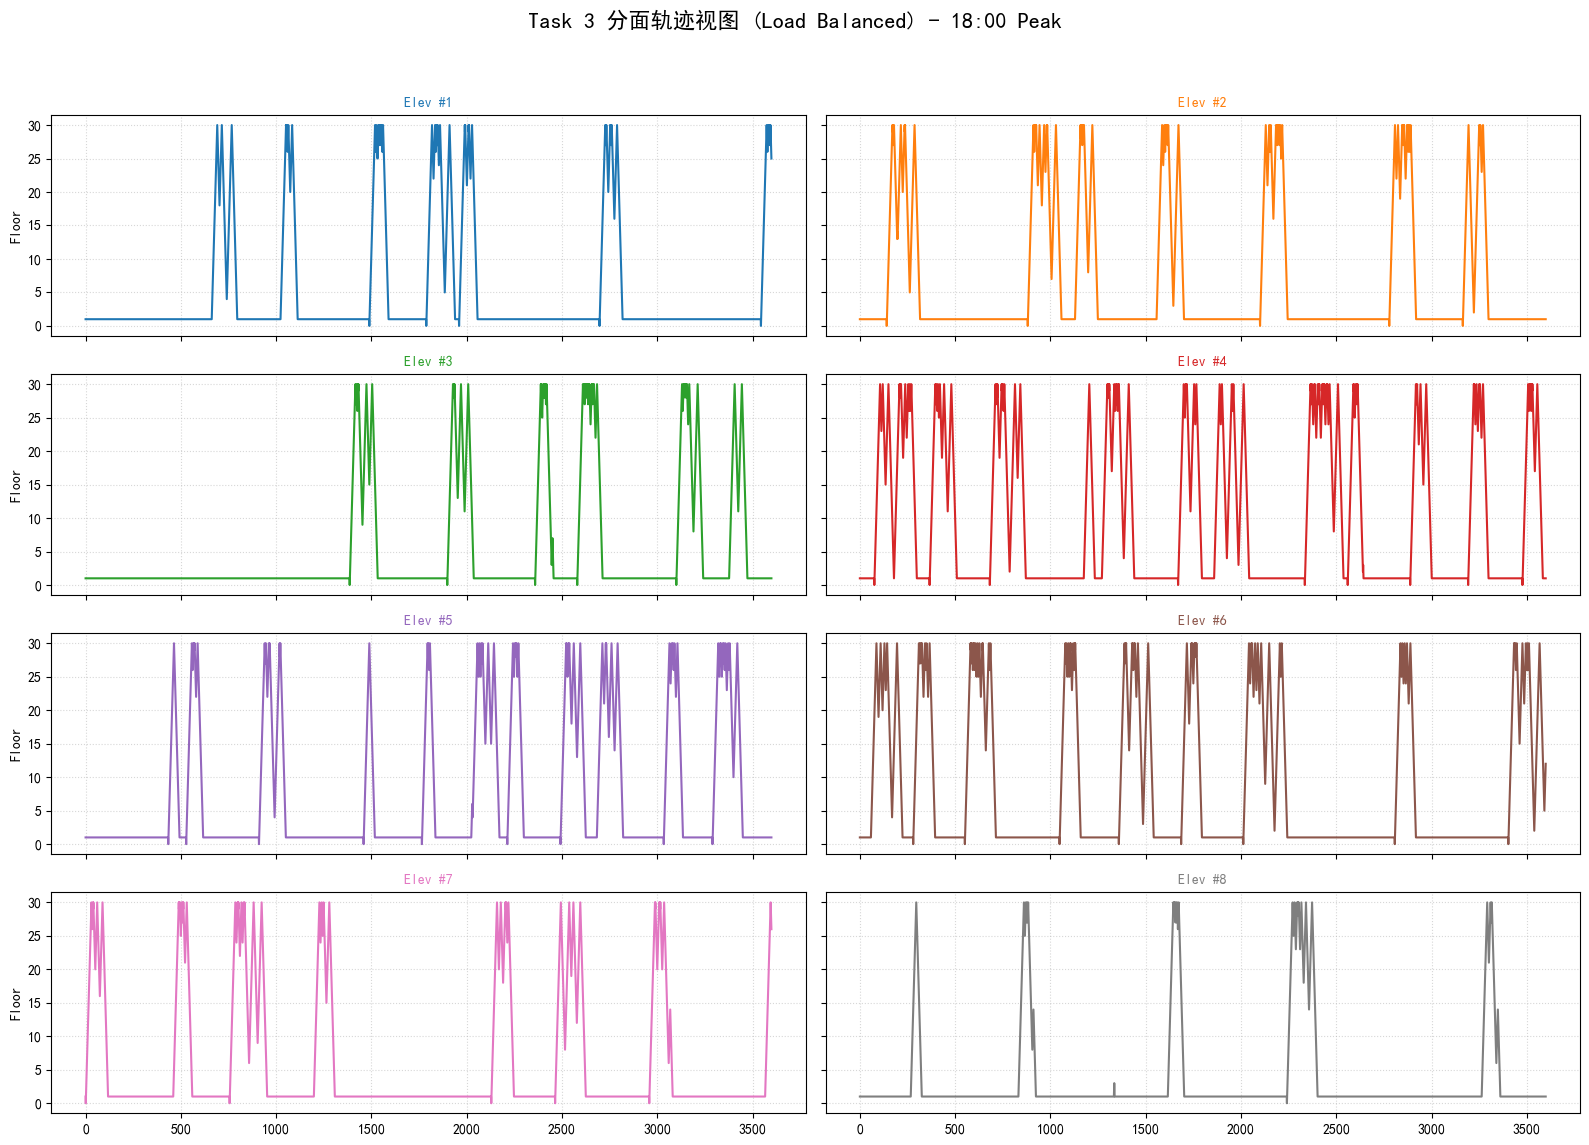

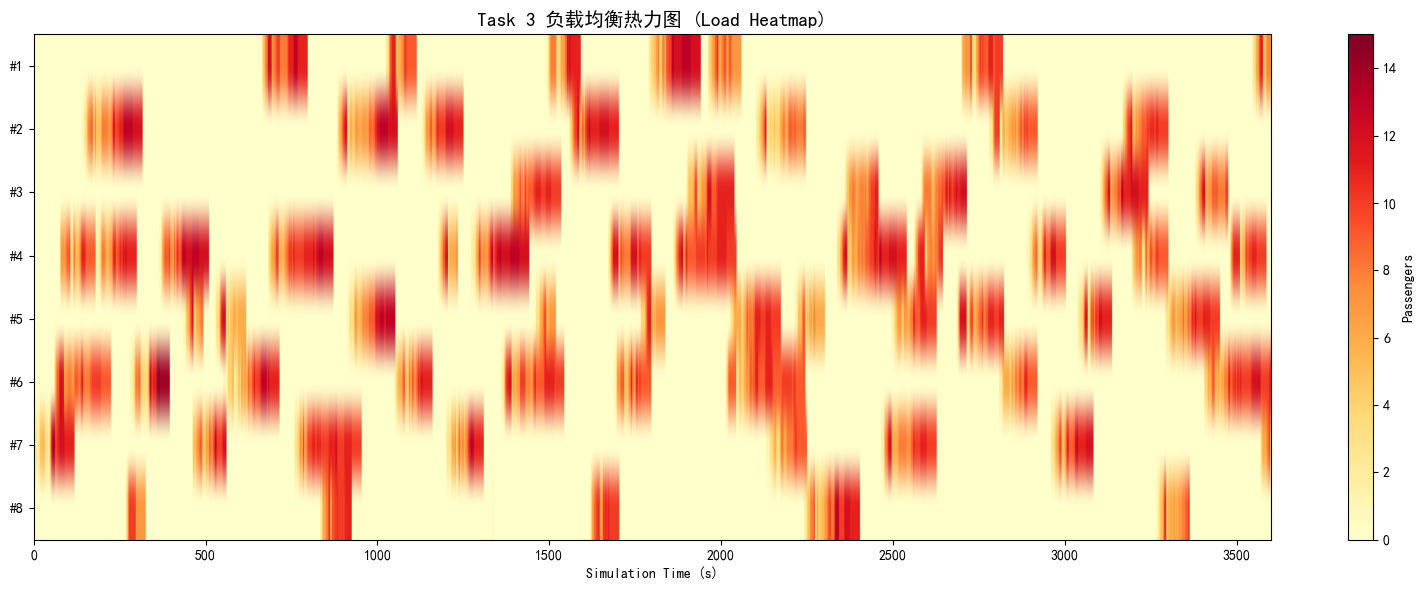


🏆 Task 3 系统性能评估报告 (Performance Report)
✅ 总服务人次: 1628
⏱️ 平均服务时间 (Avg Service Time): 41.20 秒
⚠️ 最大服务时间: 226.00 秒
📉 超长服务率 (>120s): 8.72%


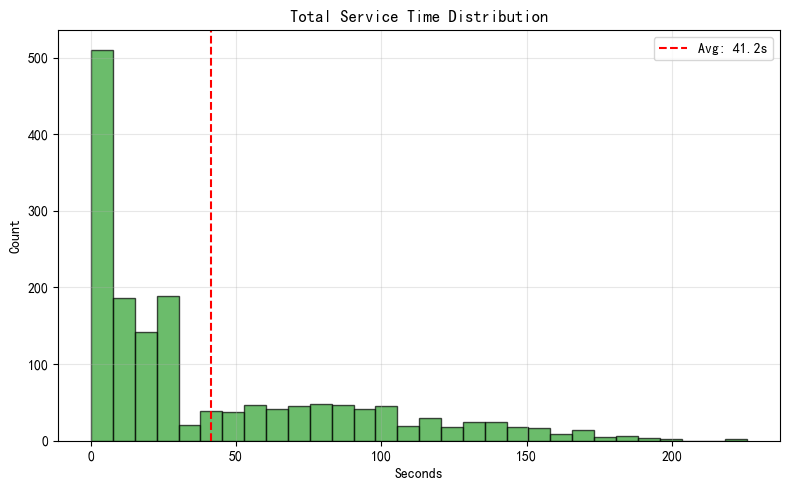

In [67]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import warnings
import os
import shutil

# 忽略警告
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 🟢 模块一：Task 1 趋势感知 (保持不变)
# ============================================================
class DemandPredictor:
    def __init__(self, raw_data):
        self.raw_data = raw_data
        self.weekday_model = None
        self.weekend_model = None
        self._train_history_models()

    def _train_history_models(self):
        df = self.raw_data.copy()
        df['Time'] = pd.to_datetime(df['Time'])
        df['DayOfWeek'] = df['Time'].dt.dayofweek 
        weekday_df = df[df['DayOfWeek'] < 5]
        weekend_df = df[df['DayOfWeek'] >= 5]
        self.weekday_model = self._fit_poly(weekday_df)
        self.weekend_model = self._fit_poly(weekend_df)

    def _fit_poly(self, df):
        if len(df) == 0: return lambda x: 0
        traffic = df.set_index('Time').resample('5min').size().reset_index()
        traffic.columns = ['Time', 'Count']
        traffic['minutes'] = traffic['Time'].dt.hour * 60 + traffic['Time'].dt.minute
        x = traffic['minutes'].values
        y = traffic['Count'].values
        if len(x) > 10:
            coeffs = np.polyfit(x, y, deg=6)
            return np.poly1d(coeffs)
        else:
            return lambda x: 0

    def get_realtime_trend_data(self, current_seconds, day_specific_lookup, is_weekend, window=15):
        current_minutes = (current_seconds // 60) % 1440
        x_local = []
        y_local = []
        for m in range(current_minutes - window, current_minutes, 5):
            val = day_specific_lookup.get(m, 0)
            x_local.append(m)
            y_local.append(val)
        if len(x_local) < 2: return 0, 0 

        coeffs = np.polyfit(x_local, y_local, deg=1)
        slope = coeffs[0] 
        func = np.poly1d(coeffs)
        pred_realtime = max(0, func(current_minutes))
        
        if is_weekend:
            pred_history = max(0, self.weekend_model(current_minutes))
        else:
            pred_history = max(0, self.weekday_model(current_minutes))
        
        alpha = 0.4 
        if pred_realtime > pred_history: alpha = 0.8 
        if slope > 1.2:
            pred_realtime *= 1.15
            alpha = max(alpha, 0.9)
            
        final_pred = (1 - alpha) * pred_history + alpha * pred_realtime
        return final_pred, slope

# ============================================================
# 🟡 模块二：Task 2 模式选择 (保持不变)
# ============================================================
class ModeSelector:
    def __init__(self, raw_data):
        self.raw_data = raw_data
        self.valid_windows = {'UP_PEAK': (6, 10), 'LUNCH': (11, 14), 'DOWN_PEAK': (16, 20)}
        self.thresholds = {}
        self._learn_activation_thresholds()

    def _learn_activation_thresholds(self):
        temp = self.raw_data.copy()
        temp['Time'] = pd.to_datetime(temp['Time'])
        traffic = temp.set_index('Time').resample('5min').size()
        base_line = traffic.quantile(0.55) if len(traffic)>0 else 10
        alert_line = traffic.quantile(0.40) if len(traffic)>0 else 5
        self.thresholds['HARD_TRIGGER'] = max(8, base_line)
        self.thresholds['SOFT_TRIGGER'] = max(5, alert_line)
        self.thresholds['TREND_SLOPE'] = 1.5

    def get_mode(self, current_seconds, pred_demand, trend_slope):
        hour = (current_seconds // 3600) % 24
        possible_mode = 'OFF_PEAK'
        for mode, (start, end) in self.valid_windows.items():
            if start <= hour < end:
                possible_mode = mode
                break
        if possible_mode == 'OFF_PEAK': return 'OFF_PEAK'
        if pred_demand >= self.thresholds['HARD_TRIGGER']: return possible_mode
        elif (pred_demand >= self.thresholds['SOFT_TRIGGER']) and (trend_slope >= self.thresholds['TREND_SLOPE']): return possible_mode
        return 'OFF_PEAK'

# ============================================================
# 🔴 模块三：Task 3 动态群控 (严格复刻负载均衡逻辑)
# ============================================================
MODE_WEIGHTS = {
    'UP_PEAK':   [1.0, 15.0, 50.0, 30.0, 20.0, 10.0], 
    'DOWN_PEAK': [1.0, 10.0, 50.0, 30.0, 5.0,  30.0],
    'LUNCH':     [2.0, 2.0,  30.0, 20.0, 2.0,  5.0],  
    'OFF_PEAK':  [1.0, 1.0,  10.0, 10.0, 0.0, 0.0]   
}

def calculate_dynamic_cost(elev, req_floor, mode, pred_demand, slope, all_elevators):
    # 1. 满载熔断 (超过15人直接不接单)
    if elev.load_count >= 15: return float('inf')

    w1, w2, w3, w4, w5, w6 = MODE_WEIGHTS.get(mode, MODE_WEIGHTS['OFF_PEAK'])
    
    # 2. 基础物理代价
    dist_cost = abs(elev.current_floor - req_floor)
    
    # 3. 忙碌惩罚 (指数级) -> 关键点！
    # 这里使用的是 elev.load_count，它包含了已分配的所有任务
    # 只要分了一个任务，代价立马平方级上升，逼迫系统分给别人
    load_cost = elev.load_count ** 2 
    task_cost = len(elev.stops) ** 2
    
    # 4. 方向惩罚
    dir_cost = 0
    if elev.state != 'IDLE':
        if (elev.direction == 1 and req_floor < elev.current_floor) or \
           (elev.direction == -1 and req_floor > elev.current_floor):
            dir_cost = 50 
            
    # 5. 趋势势能
    potential_cost = 0
    trend_factor = 1.0 + max(0, slope * 0.5) 
    if mode == 'UP_PEAK':
        potential_cost = (elev.current_floor * pred_demand) * trend_factor
    elif mode == 'DOWN_PEAK':
        potential_cost = ((30 - elev.current_floor) * (pred_demand * 0.1)) * trend_factor

    # 6. 空间排斥
    bunching_cost = 0
    if mode != 'OFF_PEAK':
        for teammate in all_elevators:
            if teammate.id == elev.id: continue
            dist_to_mate = abs(teammate.current_floor - elev.current_floor)
            if dist_to_mate < 4 and teammate.direction == elev.direction:
                bunching_cost += (50.0 / (dist_to_mate + 1))

    total_cost = (w1 * dist_cost) + (w2 * dir_cost) + (w3 * load_cost) + \
                 (w4 * task_cost) + (w5 * potential_cost) + (w6 * bunching_cost)
                 
    return total_cost

# ============================================================
# 🏗️ 仿真对象 (回退到最稳健的逻辑)
# ============================================================
class SmartElevator:
    def __init__(self, id):
        self.id = id
        self.current_floor = 1
        self.direction = 0 
        self.state = 'IDLE'
        self.stops = set() 
        # 这里的 passengers 列表只存简单的字典，不搞复杂状态机
        self.passengers = [] 
        
        self.history_pos = []  
        self.history_load = [] 
        
        # ✅ 新增：简单的日志列表，用来存完成的时间
        self.service_logs = [] 

    @property
    def load_count(self):
        # 只要在列表里就算负载。
        # 这是负载均衡的关键：一派单，立马算人头，立马增加代价。
        return len(self.passengers)

    def move(self, current_time):
        self.history_pos.append(self.current_floor)
        self.history_load.append(self.load_count)
        
        if self.state == 'IDLE': return
        self.current_floor += self.direction
        
        # 到达停靠点
        if self.current_floor in self.stops:
            self.stops.remove(self.current_floor)
            
            # 1. 卸客逻辑
            remaining_passengers = []
            for p in self.passengers:
                if p['dest'] == self.current_floor:
                    # 乘客到达目的地，记录时间
                    # 总服务时间 = 当前时间 - 请求时间
                    service_time = current_time - p['req_time']
                    self.service_logs.append(service_time)
                else:
                    remaining_passengers.append(p)
            self.passengers = remaining_passengers
            
        if not self.stops:
            self.state = 'IDLE'
            self.direction = 0
        elif max(self.stops, default=0) > self.current_floor:
            self.direction = 1
        elif min(self.stops, default=99) < self.current_floor:
            self.direction = -1

# ============================================================
# 🎮 仿真总控中心
# ============================================================
class SimulationController:
    def __init__(self, data_path):
        try:
            self.full_df = pd.read_csv(data_path)
        except:
            self.full_df = pd.read_csv(data_path, encoding='gbk')
        self.full_df['Time'] = pd.to_datetime(self.full_df['Time'])
        self.full_df['Floor'] = pd.to_numeric(self.full_df['Floor'], errors='coerce').fillna(1).astype(int)
        
        self.predictor = DemandPredictor(self.full_df)
        self.mode_selector = ModeSelector(self.full_df)
        self.elevators = [SmartElevator(i) for i in range(1, 9)] 
        
        self.output_dir = 'MCM_Simulation_Results' 
        self._initialize_output_folder()

    def _initialize_output_folder(self):
        if os.path.exists(self.output_dir):
            try: shutil.rmtree(self.output_dir)
            except: pass
        os.makedirs(self.output_dir, exist_ok=True)
        print(f"📂 输出目录已就绪: {os.path.abspath(self.output_dir)}")

    # ------------------------------------------------------------------
    # 🏃 Task 3 深度仿真 (负载均衡 + 指标统计)
    # ------------------------------------------------------------------
    def run_task3_evaluation(self):
        print("\n🚀 [图3] Task 3 深度仿真 (负载均衡测试)...")
        
        # 1. 找最忙日
        daily_counts = self.full_df.groupby(self.full_df['Time'].dt.date).size()
        busiest_date = daily_counts.idxmax()
        day_df = self.full_df[self.full_df['Time'].dt.date == busiest_date].copy()
        
        # 2. 找最忙小时
        day_df['Hour'] = day_df['Time'].dt.hour
        peak_hour = day_df.groupby('Hour').size().idxmax()
        
        print(f"🔥 压测场景: {busiest_date} | 高峰时段: {peak_hour}:00")
        
        min_time = pd.to_datetime(day_df['Time']).min()
        day_df['Seconds'] = (day_df['Time'] - pd.Timestamp(busiest_date)).dt.total_seconds()
        request_queue = day_df.sort_values('Seconds').to_dict('records')
        
        day_lookup = day_df.set_index('Time').resample('5min').size()
        day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
        
        start_seconds = peak_hour * 3600
        duration = 3600
        req_idx = 0
        
        # 快进
        while req_idx < len(request_queue) and request_queue[req_idx]['Seconds'] < start_seconds:
            req_idx += 1
            
        # 3. 仿真循环
        for t in range(duration):
            abs_time = start_seconds + t
            pred_val, slope = self.predictor.get_realtime_trend_data(abs_time, day_lookup_dict, False) 
            mode = self.mode_selector.get_mode(abs_time, pred_val, slope)
            
            while req_idx < len(request_queue) and request_queue[req_idx]['Seconds'] <= abs_time:
                req = request_queue[req_idx]
                req_idx += 1
                
                # 🔥🔥🔥 随机打乱列表 (负载均衡核心) 🔥🔥🔥
                candidate_elevators = self.elevators[:]
                random.shuffle(candidate_elevators)
                
                best_elev = None
                min_cost = float('inf')
                
                for elev in candidate_elevators:
                    cost = calculate_dynamic_cost(elev, req['Floor'], mode, pred_val, slope, self.elevators)
                    if cost < min_cost:
                        min_cost = cost
                        best_elev = elev
                
                if best_elev:
                    dest = 30 if req['Floor'] == 1 else 1 
                    # 简单分配，记录请求时间
                    best_elev.passengers.append({
                        'dest': dest,
                        'req_time': abs_time # 记录生成时间，用于算指标
                    })
                    best_elev.stops.add(req['Floor'])
                    best_elev.stops.add(dest)
                    
                    if best_elev.state == 'IDLE':
                        best_elev.state = 'MOVING'
                        best_elev.direction = 1 if req['Floor'] > best_elev.current_floor else -1
            
            for elev in self.elevators:
                elev.move(abs_time) # 传入当前时间，用于计算服务完成时间
                
        # 4. 绘图与报告
        self._plot_advanced_task3(duration, peak_hour)
        self._generate_performance_metrics()

    def _generate_performance_metrics(self):
        """生成性能指标报告"""
        all_times = []
        for elev in self.elevators:
            all_times.extend(elev.service_logs)
            
        if not all_times:
            print("⚠️ 无数据")
            return

        # 这里的 all_times 是 总服务时间 (Total System Time) = 等待 + 乘行
        # 我们用它作为主要指标
        avg_time = np.mean(all_times)
        max_time = np.max(all_times)
        long_wait_rate = (sum(1 for t in all_times if t > 120) / len(all_times)) * 100 # 假设 >120s 算很久
        
        print("\n" + "="*40)
        print("🏆 Task 3 系统性能评估报告 (Performance Report)")
        print("="*40)
        print(f"✅ 总服务人次: {len(all_times)}")
        print(f"⏱️ 平均服务时间 (Avg Service Time): {avg_time:.2f} 秒")
        print(f"⚠️ 最大服务时间: {max_time:.2f} 秒")
        print(f"📉 超长服务率 (>120s): {long_wait_rate:.2f}%")
        print("="*40)
        
        # 简单的直方图
        plt.figure(figsize=(8, 5))
        plt.hist(all_times, bins=30, color='#2ca02c', alpha=0.7, edgecolor='black')
        plt.axvline(avg_time, color='red', linestyle='--', label=f'Avg: {avg_time:.1f}s')
        plt.title('Total Service Time Distribution')
        plt.xlabel('Seconds')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'Task3_Service_Time.svg'), format='svg')
        plt.show()

    def _plot_advanced_task3(self, duration, start_hour):
        # 1. 分面轨迹图
        fig, axes = plt.subplots(4, 2, figsize=(16, 12), sharex=True, sharey=True)
        axes = axes.flatten()
        colors = plt.cm.tab10(np.linspace(0, 1, 10))
        for i, elev in enumerate(self.elevators):
            ax = axes[i]
            traj = elev.history_pos[-duration:] if len(elev.history_pos) > duration else elev.history_pos
            ax.plot(range(len(traj)), traj, color=colors[i], linewidth=1.5)
            ax.set_title(f'Elev #{i+1}', fontsize=10, fontweight='bold', color=colors[i])
            ax.grid(True, linestyle=':', alpha=0.5)
            if i % 2 == 0: ax.set_ylabel('Floor')
        fig.suptitle(f'Task 3 分面轨迹视图 (Load Balanced) - {start_hour}:00 Peak', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(os.path.join(self.output_dir, 'Task3_Separated_Trajectory.svg'), format='svg')
        plt.show()

        # 2. 负载热力图
        plt.figure(figsize=(16, 6))
        load_matrix = []
        for elev in self.elevators:
            data = elev.history_load[-duration:] if len(elev.history_load) > duration else elev.history_load
            load_matrix.append(data)
        
        im = plt.imshow(np.array(load_matrix), aspect='auto', cmap='YlOrRd', vmin=0, vmax=15)
        plt.colorbar(im, label='Passengers')
        plt.yticks(range(8), [f'#{i+1}' for i in range(8)])
        plt.xlabel('Simulation Time (s)')
        plt.title(f'Task 3 负载均衡热力图 (Load Heatmap)', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'Task3_Load_Heatmap.svg'), format='svg')
        plt.show()

    # (Task 1 & 2 的函数，保持原样)
    def run_random_day_simulation(self):
        unique_dates = self.full_df['Time'].dt.date.unique(); selected_date = random.choice(unique_dates)
        pd_date = pd.to_datetime(selected_date); is_weekend = pd_date.dayofweek >= 5
        print(f"\n🎲 [图1] 单日详情分析: {selected_date}")
        day_df = self.full_df[self.full_df['Time'].dt.date == selected_date].copy()
        day_lookup = day_df.set_index('Time').resample('5min').size()
        day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
        time_axis, actual_curve, pred_curve, errors, mode_flags = [], [], [], [], []
        for t_min in range(0, 1440, 5): 
            t_seconds = t_min * 60
            pred_val, slope = self.predictor.get_realtime_trend_data(t_seconds, day_lookup_dict, is_weekend)
            mode = self.mode_selector.get_mode(t_seconds, pred_val, slope)
            actual_val = day_lookup_dict.get(t_min, 0)
            time_axis.append(t_min / 60.0); actual_curve.append(actual_val); pred_curve.append(pred_val); errors.append(pred_val - actual_val); mode_flags.append(1 if mode != 'OFF_PEAK' else 0)
        mae = np.mean(np.abs(errors))
        self._plot_day_detail(selected_date, time_axis, actual_curve, pred_curve, errors, mae, "周末" if is_weekend else "工作日", mode_flags)

    def run_full_month_evaluation(self):
        print("\n📊 [图2] 全月趋势分析...")
        unique_dates = sorted(self.full_df['Time'].dt.date.unique())
        date_list, mae_list = [], []
        for date in unique_dates:
            pd_date = pd.to_datetime(date); is_weekend = pd_date.dayofweek >= 5
            day_df = self.full_df[self.full_df['Time'].dt.date == date]
            day_lookup = day_df.set_index('Time').resample('5min').size()
            day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
            daily_errors = []
            for t_min in range(0, 1440, 5):
                t_seconds = t_min * 60
                pred_val, _ = self.predictor.get_realtime_trend_data(t_seconds, day_lookup_dict, is_weekend)
                actual_val = day_lookup_dict.get(t_min, 0)
                daily_errors.append(abs(pred_val - actual_val))
            mae_list.append(np.mean(daily_errors)); date_list.append(date)
        self._plot_monthly_trend(date_list, mae_list, np.mean(mae_list))

    def _plot_day_detail(self, date, x, y_actual, y_pred, errors, mae, day_type, modes):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        ax1.plot(x, y_actual, label='真实', color='gray', linestyle=':', alpha=0.6)
        ax1.plot(x, y_pred, label='预测', color='#d62728', linewidth=2.5)
        ax1.fill_between(x, 0, max(max(y_actual), max(y_pred))*1.2, where=modes, color='#ff7f0e', alpha=0.15, label='高峰模式')
        ax1.set_title(f'单日预测详情: {date} [{day_type}] (MAE: {mae:.2f})'); ax1.legend(); ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, max(max(y_actual), max(y_pred)) * 1.1)
        ax2.bar(x, errors, color='#ff7f0e', alpha=0.7, width=0.05); ax2.axhline(0, color='black')
        ax2.set_xlabel('Time (h)'); ax2.set_ylabel('偏差'); ax2.grid(True, alpha=0.3); plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f'Task1_Detail_{date}.svg'), format='svg'); plt.show()

    def _plot_monthly_trend(self, dates, maes, avg_line):
        plt.figure(figsize=(14, 6))
        plt.plot(dates, maes, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
        plt.axhline(y=avg_line, color='red', linestyle='--', label=f'平均误差: {avg_line:.2f}')
        max_idx = np.argmax(maes)
        plt.annotate(f'Max: {maes[max_idx]:.2f}', xy=(dates[max_idx], maes[max_idx]), xytext=(dates[max_idx], maes[max_idx]+2), arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontweight='bold')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')); plt.gcf().autofmt_xdate()
        plt.title('全月模型稳定性分析'); plt.legend(); plt.grid(True, linestyle=':', alpha=0.5); plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'Task1_Monthly_Trend.svg'), format='svg'); plt.show()

# ============================================================
# ▶️ 执行区域
# ============================================================
if __name__ == "__main__":
    # 智能搜索路径
    possible_paths = [
        'hall_calls.csv',
        'mcm26Train-B-Data/hall_calls.csv',
        '../hall_calls.csv',
        '../mcm26Train-B-Data/hall_calls.csv',
        '../../mcm26Train-B-Data/hall_calls.csv'
    ]
    data_path = None
    for p in possible_paths:
        if os.path.exists(p):
            data_path = p
            break
            
    if data_path:
        print(f"📂 成功加载数据: {data_path}")
        sim = SimulationController(data_path)
        sim.run_random_day_simulation() # Task 1 & 2
        sim.run_full_month_evaluation() # Task 1 Stability
        sim.run_task3_evaluation()      # Task 3
    else:
        print("❌ 找不到文件 hall_calls.csv")